In [ ]:

from pathlib import Path
import geopandas as gpd
import os 
import zipfile
import numpy as np
import richdem as rd
from os import walk
from os.path import join
from pathlib import Path
import rasterio

directory = '/Users/corina/3keel/terr50_gagg_gb/data'
# out_dir = '/Users/corina/3keel/filetred_data/'
out_dir = '/Users/corina/3keel/filetred_data'
ext = '.asc'

def read_vector_data():
    """Read the grid and the boundaries vector files as geopandas
    """
    grid = gpd.read_file("/Users/corina/3keel/os_bng_grids_10km_explode.gpkg", layer='10k_exploded')
    print(grid)
    boundary = gpd.read_file("/Users/corina/3keel/GBR_adm0_line_27700_single_part.shp")
    boundary = boundary[['fid', 'geometry']]
    return grid, boundary


def get_zipped_files():
    """Get all the zipped files that have been downloaded from the OS
    """
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".zip"):
                yield os.path.join(subdir, file)


def filter_10k_grid():
    """Filter the 10k UK grid to oget only the tiles that overlap on top of the UK coast line
    and use this later on to rebuild the path to the zipped files
    """
    grid, boundary = read_vector_data()
    intersect_grid_with_line_coast = gpd.sjoin(boundary, grid, predicate='intersects')
    remove_duplicates = intersect_grid_with_line_coast.drop_duplicates(subset=['tile_name'])
    return remove_duplicates[['id', 'tile_name']]


def main():
    """Match the filtered coast cells with the name of the zipped files
    """
    zipped = get_zipped_files()   
    # get only the file name to the zipped files 
    for zip_files in zipped: 
        filename = Path(zip_files).stem
        
    filtered_grid = filter_10k_grid()
    for tile in filtered_grid['tile_name']:
        to_lower = tile.lower() #convert the tile name to lowercase 
        spl = filename.split('_')[1] #get the second element in the file name after the underscore 
        spl2 = filename.split('_')[2] #get the third element in the file name after the underscore 
        rm_digits = ''.join(filter(lambda x: not x.isdigit(), to_lower)) #remove the numbers from the tiles to be able to pass it as a folder in the path to the zipped files
        filtered_zipped_files = Path(directory, rm_digits, f"{to_lower}_{spl}_{spl2}.zip") #reconstruct the path to the zip files but get only the files that are on the coast
        if filtered_zipped_files.is_file():
            # if the files exist, unzip it
            zip_ref = zipfile.ZipFile(filtered_zipped_files) # create zipfile object
            zip_ref.extractall(out_dir) # extract file to dir
            zip_ref.close() # close file
    
            
if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
# import elevation
import richdem as rd
from os import walk
from os.path import join
from pathlib import Path
import rasterio

directory = '/Users/corina/3keel/terr50_gagg_gb/data'
# out_dir = '/Users/corina/3keel/filetred_data/'
out_dir = '/Users/corina/3keel/filetred_data'
slope_dir = '/Users/corina/3keel/slope/'
ext = '.asc'
def create_slope_from_dem():
    allfiles = [join(dir, f) for _, dirs, files in walk(dir) for f in files if f.endswith(ext)]
    # print(allfiles)
    for asc_files in allfiles:
        shasta_dem = rd.LoadGDAL(asc_files, no_data=np.nan)
        slope = rd.TerrainAttribute(shasta_dem, attrib='slope_riserun')
        
        with rasterio.open(asc_files) as src:
            kwargs = src.meta.copy()
            kwargs.update({
                'driver': "GTiff",
                })
            filename = Path(asc_files).stem
            rm_ext = filename.removesuffix('.asc')
            with rasterio.open(f'{slope_dir}{rm_ext}.tif', 'w', **kwargs) as dst:
                dst.write(slope, 1)
if __name__ == "__main__":
    create_slope_from_dem()

In [ ]:
grid = gpd.read_file("/Users/corina/3keel/os_bng_grids_10km_explode.gpkg")
print(grid)

In [ ]:
boundary = gpd.read_file("/Users/corina/3keel/GBR_adm0_line_27700_single_part.gpkg")
print(boundary)

In [ ]:

import matplotlib.pyplot as plt
import matplotlib
import richdem as rd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (8, 5.5)

dem_path='/Users/corina/3keel/slope/HP40.tif'
shasta_dem = rd.LoadGDAL(dem_path, no_data=np.nan)



dem_path_2='/Users/corina/3keel/filetred_data/HP40.asc'
shasta_dem_2 = rd.LoadGDAL(dem_path_2, no_data=np.nan)

lst = [shasta_dem, shasta_dem_2]

for i in lst:
    
    plt.imshow(i, interpolation='none')
    # plt.imshow(shasta_dem_2, interpolation='none')

    plt.colorbar()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

import richdem as rd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# create figure
fig = plt.figure(figsize=(20, 14))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# reading images
dem_path='/Users/corina/3keel/slope/HP40.tif'
shasta_dem = rd.LoadGDAL(dem_path, no_data=np.nan)
dem_path_2='/Users/corina/3keel/filetred_data/HP40.asc'
shasta_dem_2 = rd.LoadGDAL(dem_path_2, no_data=np.nan)
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(shasta_dem)
# plt.axis('off')
plt.title("Slope")
plt.colorbar()
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(shasta_dem_2)
# plt.axis('off')
plt.title("Elevation")
plt.colorbar()
  

  


In [ ]:
import os
import rasterio
from rasterio.merge import merge
from rasterio.plot import show


slope_data = '/Users/corina/3keel/slope/'
ext = '.tif'

allfiles = [join(slope_data, f) for _, dirs, files in walk(slope_data) for f in files if f.endswith(ext)]

src_files_to_mosaic = []
for fp in allfiles:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    
# print(src_files_to_mosaic)
mosaic, out_trans = merge(src_files_to_mosaic)
show(mosaic, cmap='terrain')

In [ ]:
import rasterio
out_fp = '/Users/corina/3keel/merged2.tif'
# with rasterio.open('/Users/corina/3keel/slope/HP40.tif') as src:
  # print(src.meta)
  # out_meta = src.meta.copy()
out_meta={'driver': 'GTiff', 
            'dtype': 'float32', 
            'nodata': np.nan, 
            'width': mosaic.shape[2],
            'height': mosaic.shape[1],
            'count': 1, 
            'crs': rasterio.crs.CRS.from_epsg(27700),
            'transform': out_trans}
    

  # Update the metadata
  # out_meta.update({"driver": "GTiff",
  #                 "height": mosaic.shape[1],
  #                 "width": mosaic.shape[2],
  #                 "transform": out_trans,
  #                 "crs": rasterio.crs.CRS.from_epsg(27700)
  #                 })
  # # Write the mosaic raster to disk
with rasterio.open(out_fp, "w", **out_meta) as dest:
  dest.write(mosaic)



In [ ]:
shasta = rd.LoadGDAL(out_fp, no_data=np.nan)
plt.imshow(shasta, interpolation='none')
# plt.imshow(shasta_dem_2, interpolation='none')

plt.colorbar()
plt.show()

In [3]:

import geopandas as gpd

# grid = gpd.read_file("/Users/corina/3keel/2100_SeaLevelRise&Surge_Voronoi_27700.gpkg")
grid = gpd.read_file("/Users/corina/3keel/os_bng_grids_1km_explode.gpkg")
grid['index1'] = grid.index
print(len(grid))
coast_line = gpd.read_file("/Users/corina/3keel/data/GBR_adm0_27700_line.gpkg")
coast_line_buffer = coast_line.buffer(5)
# print(coast_line_buffer)
# boundary = boundary[['NAME_ISO', 'geometry']]
exploded = grid.explode(index_parts=False)
intersect_grid_with_line_coast = gpd.sjoin(coast_line, exploded, predicate='intersects') 
print(intersect_grid_with_line_coast)

Name_list = intersect_grid_with_line_coast["index1"].tolist()
filtered_voronoi= grid[grid['index1'].isin(Name_list)]
print(len(filtered_voronoi))
filtered_voronoi.to_file("/Users/corina/3keel/data/package_plm.gpkg", driver="GPKG")



# # print(grid['index1'])
# print(intersect_grid_with_line_coast['index1'])
# test = gpd.overlay(grid, boundary, how='intersection')
# print(Name_list)

KeyboardInterrupt: 

<AxesSubplot:>

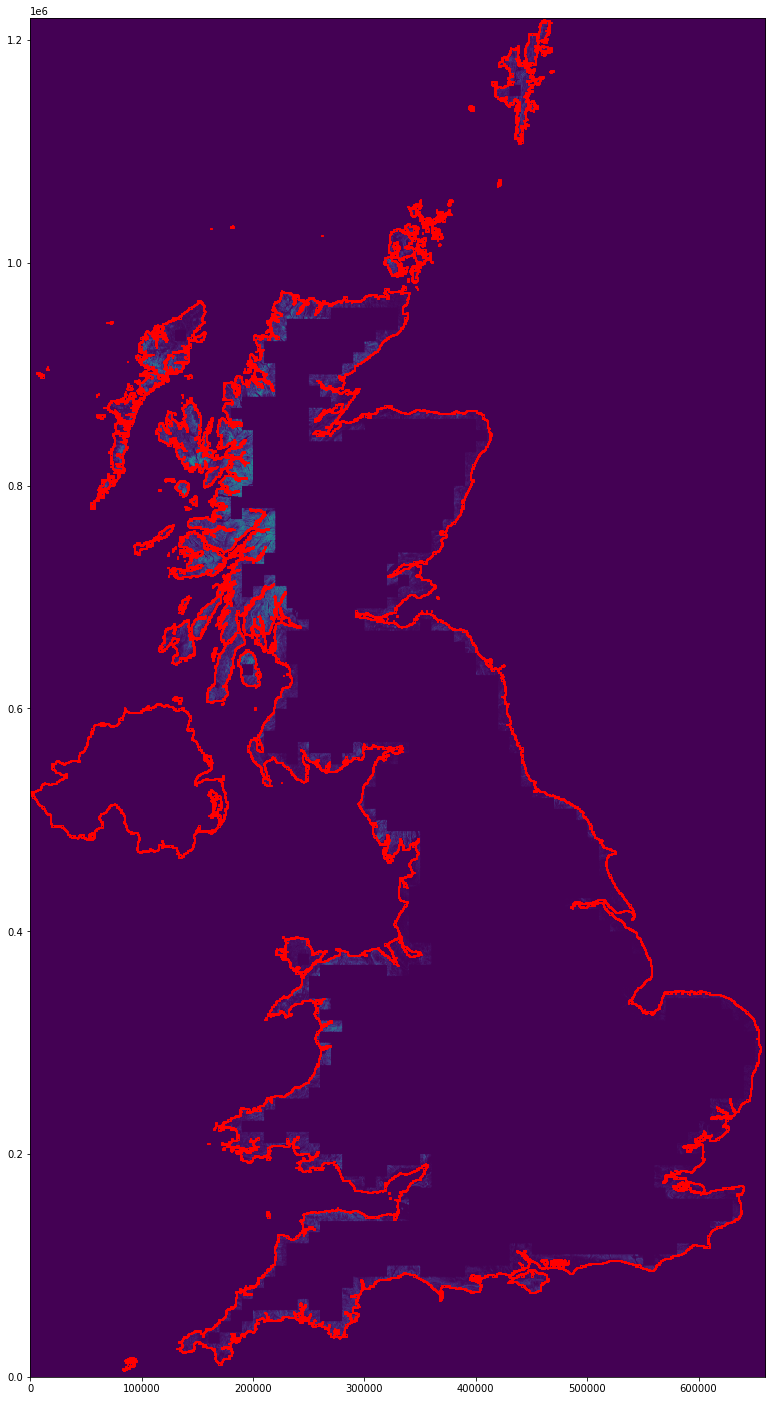

In [7]:
# https://stackoverflow.com/questions/8491927/algorithm-to-subdivide-a-polygon-in-smaller-polygons
# https://snorfalorpagus.net/blog/2016/03/13/splitting-large-polygons-for-faster-intersections/
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
import geopandas as gpd
grid = gpd.read_file("/Users/corina/3keel/package_plm.gpkg")
out_merged_raster = '/Users/corina/3keel/merged_10km.tif'
fig, ax = plt.subplots(figsize=(25, 25))
filtered_voronoi.plot(ax=ax, facecolor='none', edgecolor='red')
raster = rasterio.open(out_merged_raster)
rasterio.plot.show(raster, ax=ax)
# countries.plot(ax=ax, facecolor='none', edgecolor='red')
# coast_line.plot(ax=ax, facecolor='none', edgecolor='black')

<AxesSubplot:>

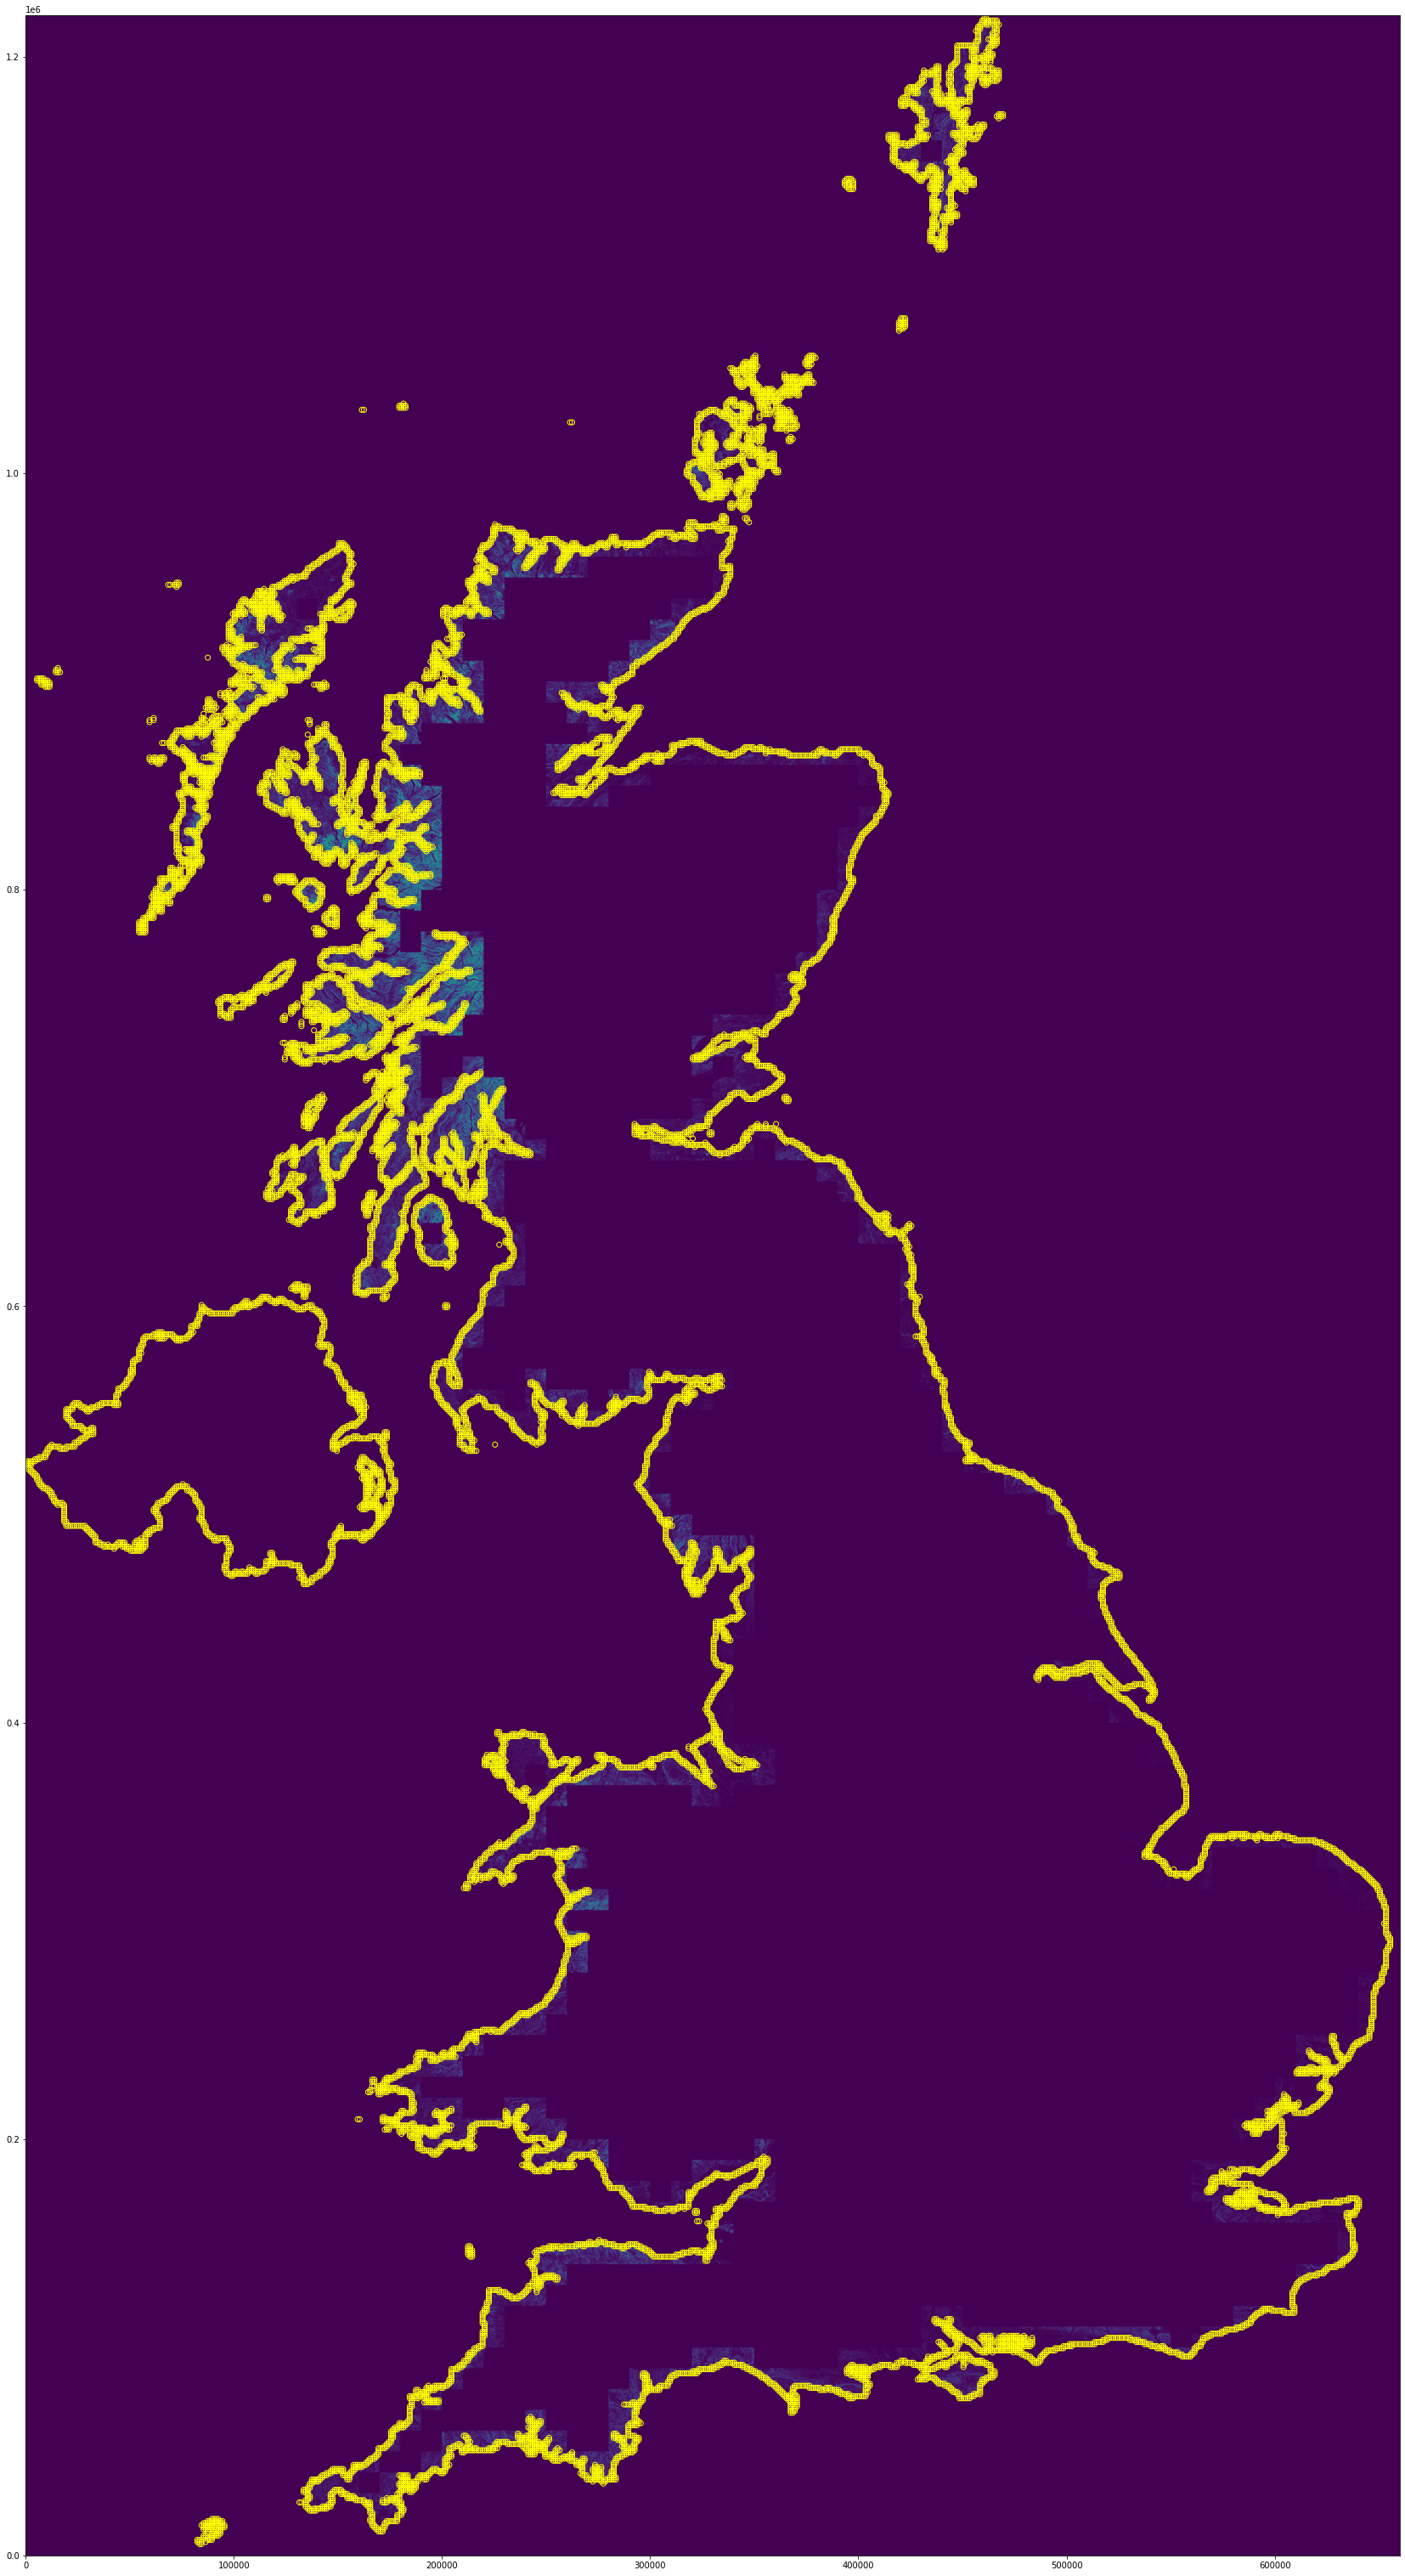

In [27]:
uk_grid_1_km = gpd.read_file('/Users/corina/3keel/1km_grid_exploded.gpkg')
# print(uk_grid_1_km.centroid)
cent = uk_grid_1_km.centroid
cent.to_file("/Users/corina/3keel/centroid.gpkg", driver="GPKG")
fig, ax = plt.subplots(figsize=(55, 55))
cent.plot(ax=ax, facecolor='none', edgecolor='yellow')
raster2 = rasterio.open(out_merged_raster)
rasterio.plot.show(raster2, ax=ax)

In [43]:
import pandas as pd
import numpy as np
from rasterstats import zonal_stats

def produce_zonal_stats(vector,raster,affine, metrics, nodata):
    gdf = gpd.read_file(vector)
    # If statement to not include add_stats if custom function is None
    stats = zonal_stats(
        gdf["geometry"],
        raster,
        affine=affine,
        stats=metrics,
        nodata=nodata,
    )
    stats = pd.DataFrame(stats)
    stats = gdf.join(stats, how="left")

    print("Finished calculating zonal stats")
    stats.to_file("/Users/corina/3keel/centroid_stats.gpkg", driver="GPKG")
    return stats


vector = "/Users/corina/3keel/centroid.gpkg"
# print(vector)
dem = rasterio.open(out_merged_raster)
array = dem.read(1)
nat_stat = produce_zonal_stats(vector,array, dem.profile['transform'], ['min', 'max', 'mean'], nodata=np.nan)


Finished calculating zonal stats


687       107.367194
2         169.550706
6         308.010129
7         185.828737
8         101.656187
            ...     
18928     399.707569
18929    3440.013607
18930     463.117597
18932     318.463294
18934    1050.114565
Name: add_Swrl5_divided_by_slope, Length: 10252, dtype: float64


<AxesSubplot:>

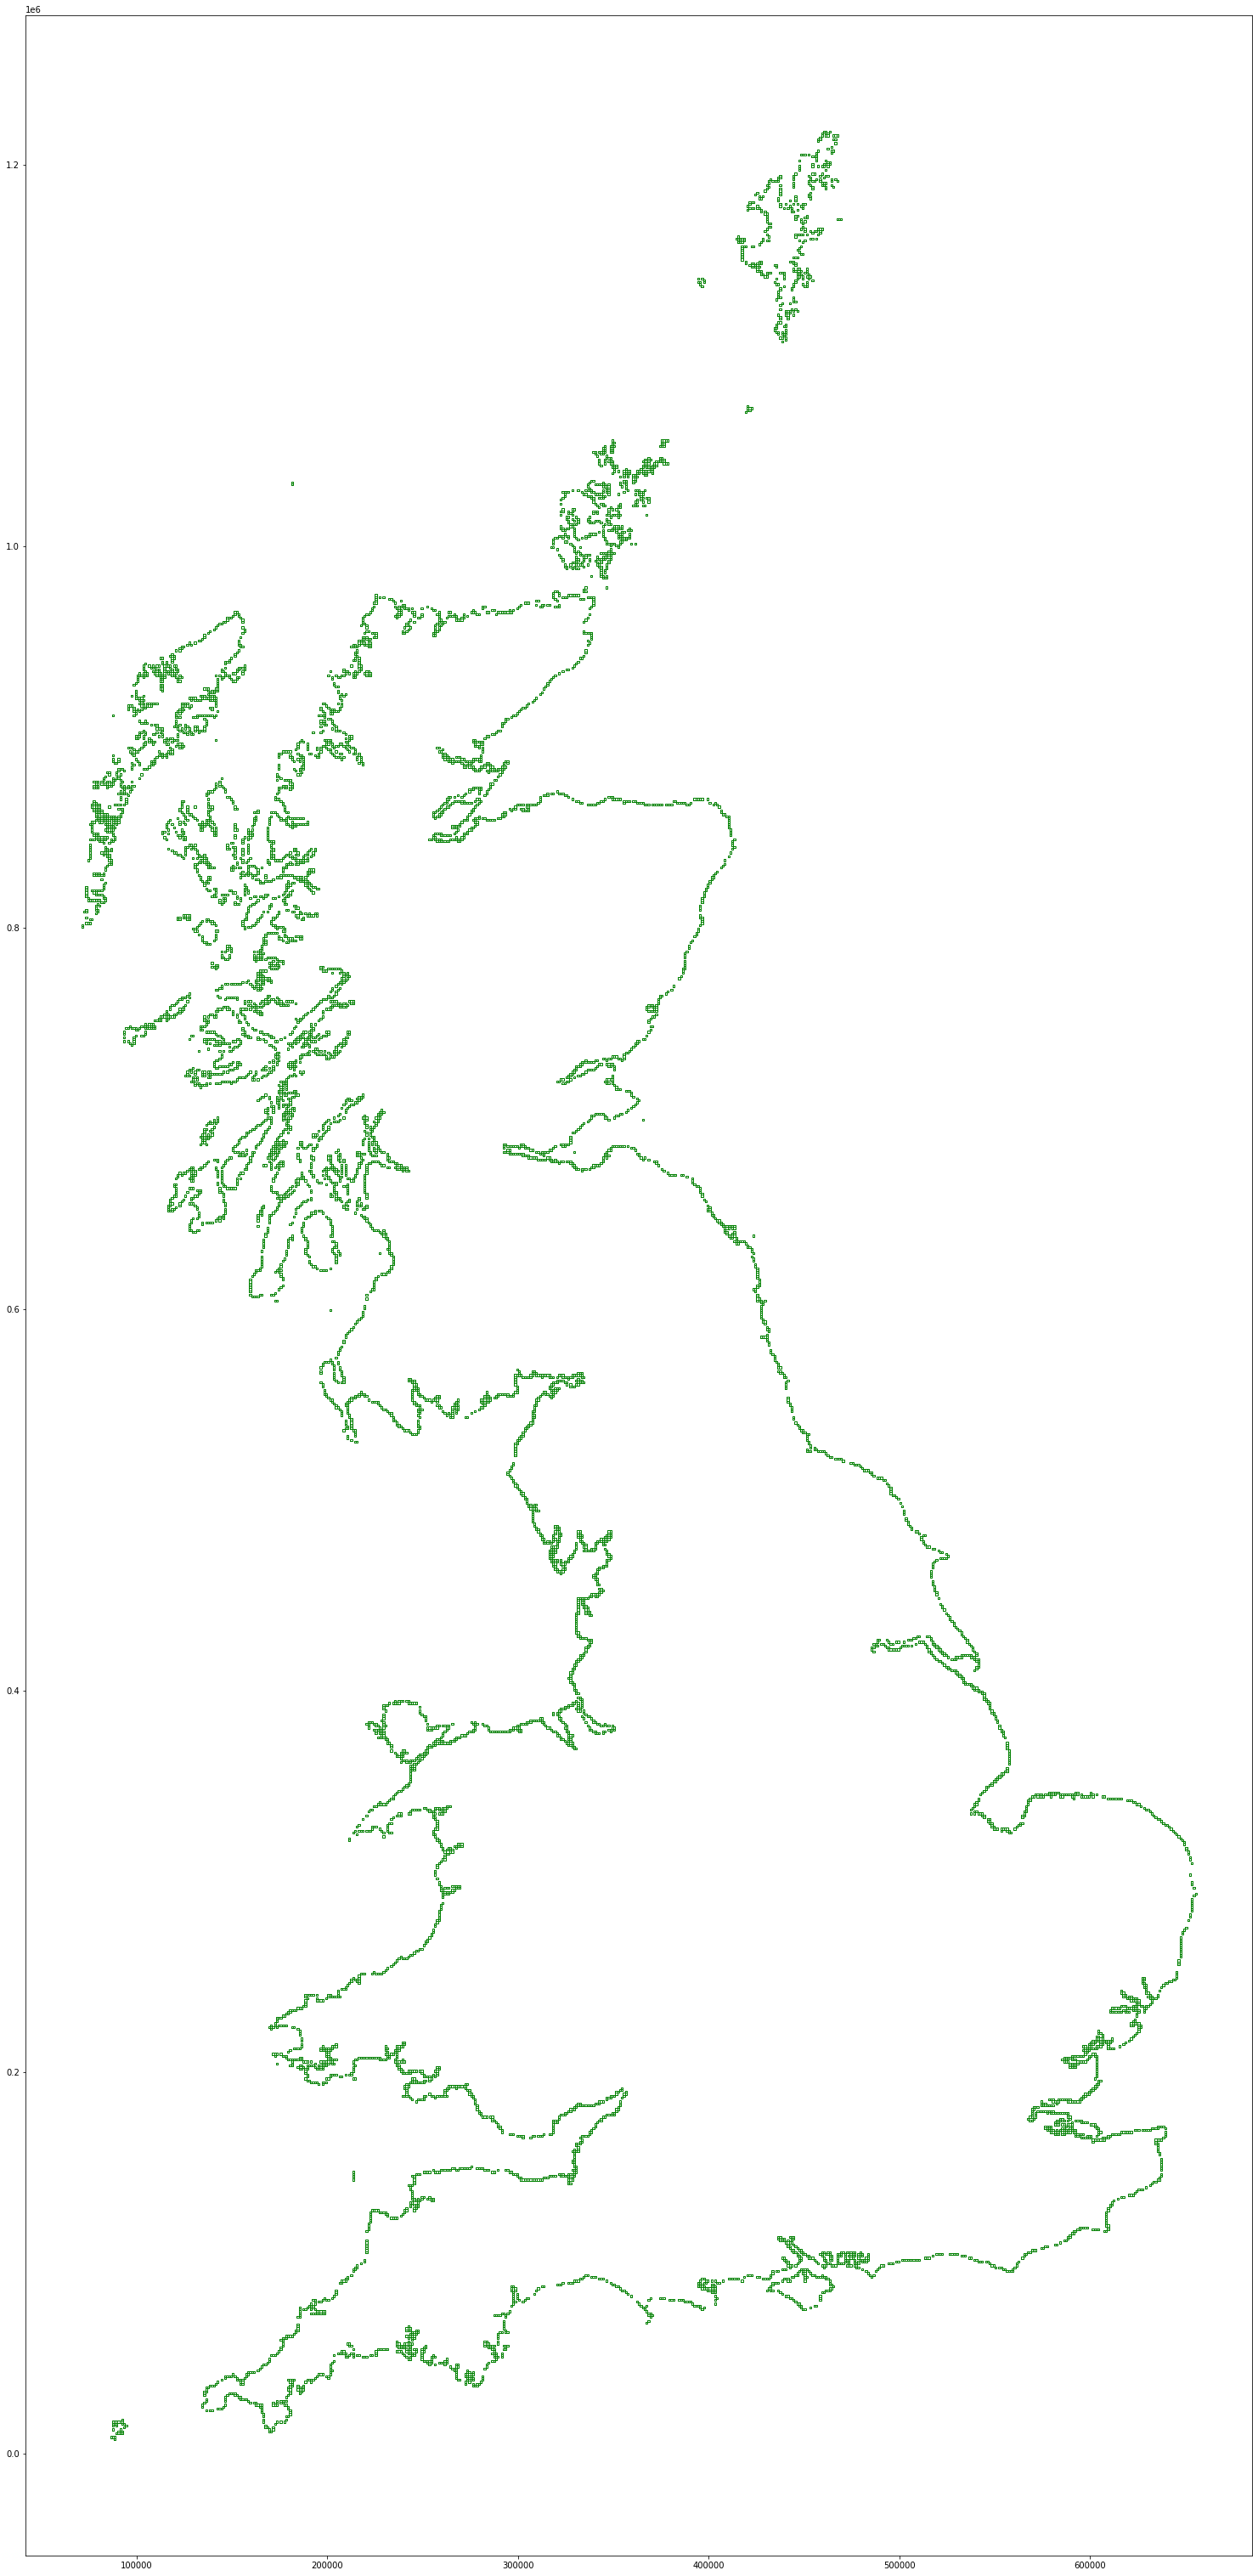

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None

point = gpd.read_file("/Users/corina/3keel/centroid_stats.gpkg")
poly = gpd.read_file('/Users/corina/3keel/1km_grid_exploded.gpkg')
vornoi=gpd.read_file("/Users/corina/3keel/2100_SeaLevelRise&Surge_Voronoi_27700.gpkg")
join_poly_point = poly.sjoin(point, how="left")
# print(join_poly_point)
join_poly_point = join_poly_point.drop(['index_right'], axis=1)
join_voronoi_uk_grid = join_poly_point.sjoin(vornoi, how="inner").drop_duplicates(subset=['tile_name'])
join_voronoi_uk_grid.rename(columns={"mean": "slope_value"}, inplace=True)
# join_voronoi_uk_grid.drop(['min', 'max', 'ID_0', 'ISO', 'NAME_0', 'layer', "ISO"], axis=1, inplace=True)
voronoi_uk_grid = join_voronoi_uk_grid[['tile_name','slope_value', 'LT_05_local', 'LT_50_local', 'LT_95_local', 'SWRL_MT', 'slrbLT_50', 'swrl-slr50', 'Add-Swrl5', 'geometry']]
voronoi_uk_grid['add_Swrl5_divided_by_slope'] = voronoi_uk_grid['Add-Swrl5'] / voronoi_uk_grid['slope_value']
voronoi_uk_grid['add_Swrl5_divided_by_slope'].replace([np.inf, -np.inf], 0, inplace=True)
# voronoi_uk_grid['add_Swrl5_divided_by_slope'].replace([np.inf, -np.inf], np.nan, inplace=True)
# voronoi_uk_grid.dropna(subset=["add_Swrl5_divided_by_slope"], how="all", inplace=True)

print(voronoi_uk_grid['add_Swrl5_divided_by_slope'])
# print('join_voronoi_uk_grid', len(voronoi_uk_grid))
# print('poly', len(poly))

# print(join_voronoi_uk_grid)
fig, ax = plt.subplots(figsize=(55, 55))
# voronoi_uk_grid.to_file("/Users/corina/3keel/uk_grid_voronoi_slope.gpkg", driver="GPKG")
voronoi_uk_grid.plot(ax=ax, facecolor='none', edgecolor='green')